## Preprocessing and EDA

This section will detail the preprocessing and EDA portion of the report. This will lead us up to the training of two separate models, Resnet18 and EfficientNet.

First we import all required libraries. We assume all libraries have been previously installed.

In [10]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import kagglehub
from typing import List
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import math
from typing import List, Tuple
from collections import Counter
import seaborn as sns

Below we have downloaded the dataset and observe all folders where our data is located [1].

In [11]:
# Download latest version of the dataset
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print(os.listdir(path))

train_df_path =  os.path.join(path, "Train.csv")
test_df_path =  os.path.join(path, "Test.csv")

train_img_path =  os.path.join(path, "Train")
test_img_path =  os.path.join(path, "Test")

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']


In [12]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

train_df.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png

Just from this snippet, evident that images will vary in pixel size (see width and height column). This issue will be tackled later. The "Roi" columns reflect the upper left and lower right pixels coordinates of the sign in the image, whilst ClassId simply classifies the type of sign. 

For meaningful EDA to be conducted, we create a new variable that transforms the ClassId column to be more descriptive of the observation [2]. 

In [13]:
print(f"Total classes: {train_df['ClassId'].nunique()}")

Total classes: 43


In [14]:
class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

train_df["ClassName"] = train_df['ClassId'].map(class_names)
test_df["ClassName"] = test_df['ClassId'].map(class_names)

train_df.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path           ClassName  
0  Train/20/00020_00000_00000.png  Single curve right  
1  Train/20/00020_00000_00001.png  Single curve right  
2  Train/20/00020_00000_00002.png  Single curve right  
3  Train/20/00020_00000_00003.png  Single curve right  
4  Train/20/00020_00000_00004.png  Single curve right

We can see the difference in observations per class below (remember this is only from our training data) and then plot a histogram of said data.

In [15]:
train_df['ClassName'].value_counts()

ClassName
Speed Limit (50Km/hr)                           2250
Speed Limit (30Km/hr)                           2220
Yeild right of way                              2160
Priotity Road                                   2100
Keep right                                      2070
No Passing for trucks over 3.5 tons             2010
Speed Limit (70Km/hr)                           1980
Speed Limit (80Km/hr)                           1860
Construction side ahead                         1500
No Passing                                      1470
Speed Limit (100Km/hr)                          1440
Speed Limit (60Km/hr)                           1410
Speed Limit (120Km/hr)                          1410
Right of way                                    1320
Mandatory direction of travel ahead             1200
Danger                                          1200
Entery prohibited                               1110
Stop                                             780
Wild animal crossing                

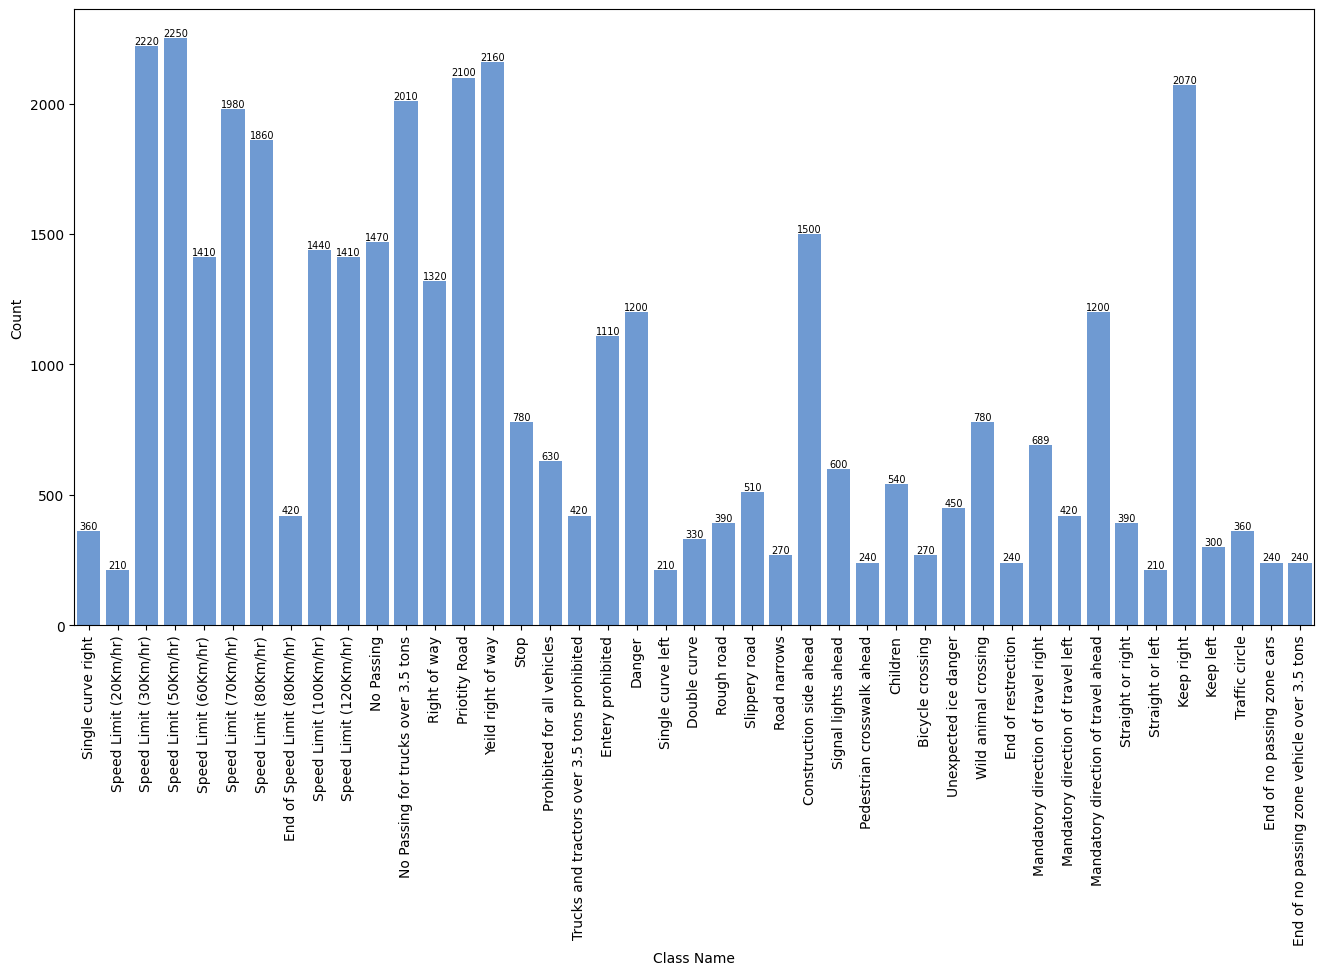

In [16]:
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=train_df, x="ClassName", color="#5F98E2")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fontsize=7)
plt.show()

We can order these observations to better visualise the disparity between certain classes. 

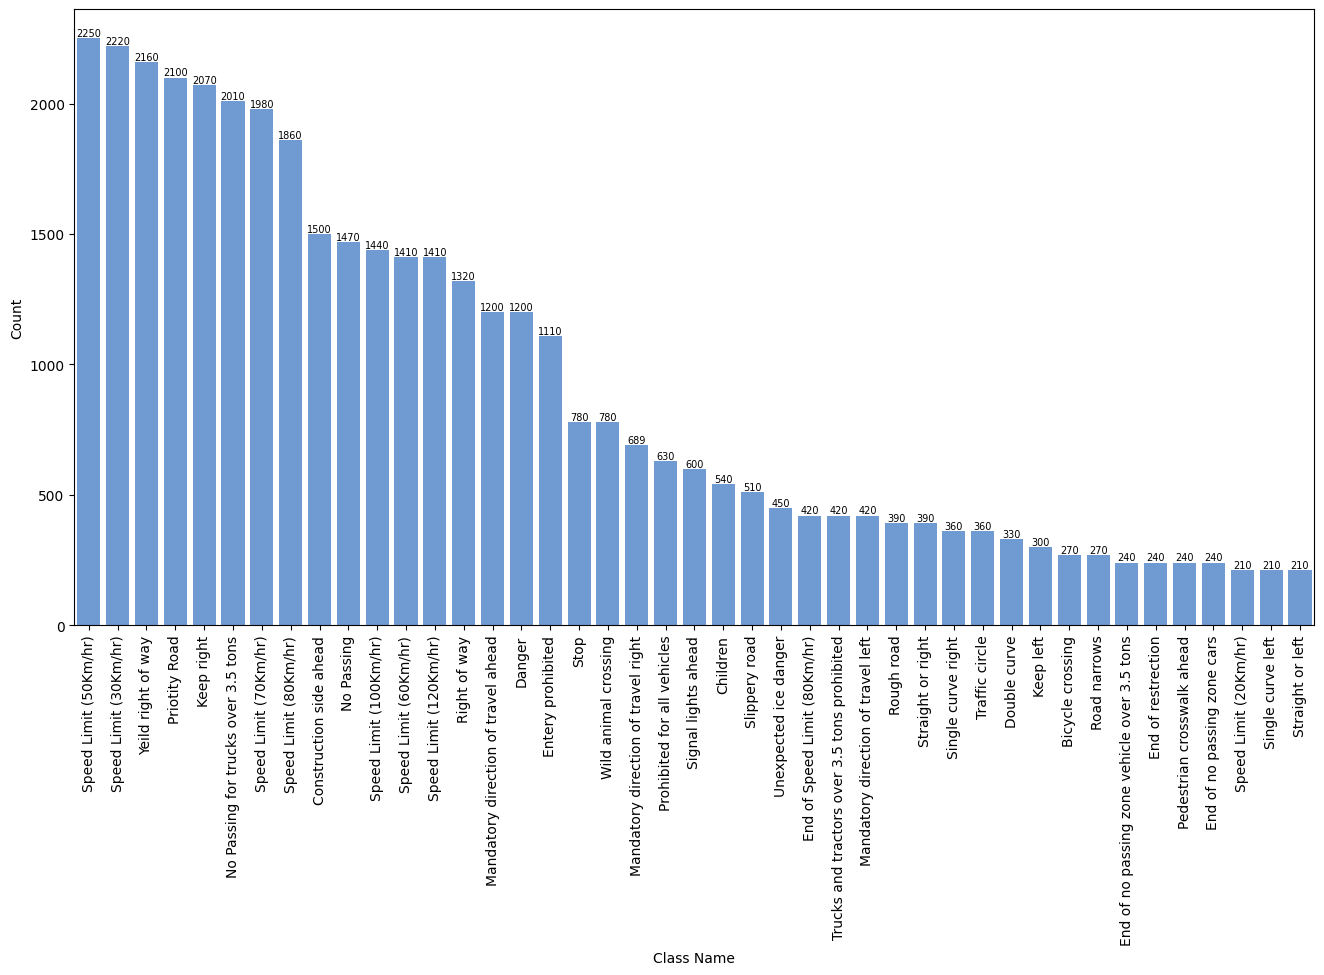

In [17]:
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=train_df, x="ClassName", order=train_df["ClassName"].value_counts().index, color="#5F98E2") # ordered by count
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fontsize=7)
plt.show()

The dataset clearly has large class imbalances, with large variation in the number of images per category. Such imbalance can heavily influence model performance, particularly by biasing training towards overrepresented classes. We calculate various descriptive statistics for a better understanding.

In [18]:
print(f"Maximum images per class: {train_df['ClassName'].value_counts().max()} (Class: {train_df['ClassName'].value_counts().idxmax()})\n")
print(f"Minimum images per class: {train_df['ClassName'].value_counts().min()} (Class: {train_df['ClassName'].value_counts().idxmin()})\n")
print(f"Images per class range: {train_df['ClassName'].value_counts().max() - train_df['ClassName'].value_counts().min()}\n")
print(f"Mode images per class: {train_df['ClassName'].value_counts().mode()[0]}\n")
print(f"Median images per class: {train_df['ClassName'].value_counts().median()}\n")
print(f"Average images per class: {train_df['ClassName'].value_counts().mean():.1f}\n")

Maximum images per class: 2250 (Class: Speed Limit (50Km/hr))

Minimum images per class: 210 (Class: Speed Limit (20Km/hr))

Images per class range: 2040

Mode images per class: 240

Median images per class: 600.0

Average images per class: 911.8



We see that the difference in images per class can be as high as 2000. This further emphaises our point in that our model may be biased towards more overrepresented classes. The average images per class is roughly 900, which seems to be a good inbetween 200 and 2000.

So far we have yet to actually observe what our training data appears as. We will now randomly generate images so that we can further understand the data we are working with. 

In [19]:
# Function to generate a random image from a specified class
def random_image_generator(class_id):
    if class_id < 0 or class_id > 42:
        raise ValueError("class_id must be between 0 and 42 inclusive.")

    folder = os.path.join(train_img_path, str(class_id))
    image_files = [f for f in os.listdir(folder) if not f.startswith(".")]

    filename = random.choice(image_files)
    sample_path = os.path.join(folder, filename)

    img = Image.open(sample_path)

    return img

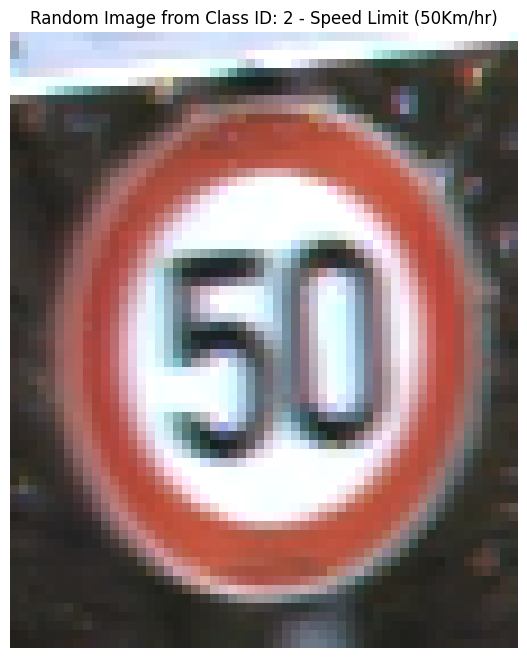

In [20]:
random_class = random.randint(0, 42)
img1 = random_image_generator(random_class)
# Display the random image
plt.figure(figsize=(8,8))
plt.title(f"Random Image from Class ID: {random_class} - {class_names[random_class]}")
plt.imshow(img1)
plt.axis("off")
plt.show()

One can extend this function to incorporate multiple images. This will allow us to easily see variations in different types of images, whilst also developing a certain familiarity with the appearance of traffic signs within our dataset.

In [21]:
def get_image_paths(filepath: str) -> Tuple[List[str], List[str]]:
    image_paths = []
    class_labels = []

    for root, _, files in os.walk(filepath):
        for filename in files:
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".ppm", ".bmp")):
                full_path = os.path.join(root, filename)
                image_paths.append(full_path)

                # grab class folder name
                class_id = os.path.basename(root)
                class_labels.append(class_id)

    return image_paths, class_labels

train_image_paths, train_labels = get_image_paths(train_img_path)

In [22]:
def print_sample_images(n, cols):
    total = len(train_image_paths)
    num_images = min(n*cols, total)

    if num_images >= total:
        print("WARNING: Total images exceed available images. Returning all available images. This may take a while.")

    if (n, cols) >= (100, 5):
        print("WARNING: You are attempting to plot many images. This may take a while.")

    plt.figure(figsize=(cols*3, n*3))

    for i, k in enumerate(random.sample(range(total), num_images), start=1):
        img = plt.imread(train_image_paths[k])
        plt.subplot(n, cols, i)
        plt.imshow(img)
        plt.title(class_names[int(train_labels[k])])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

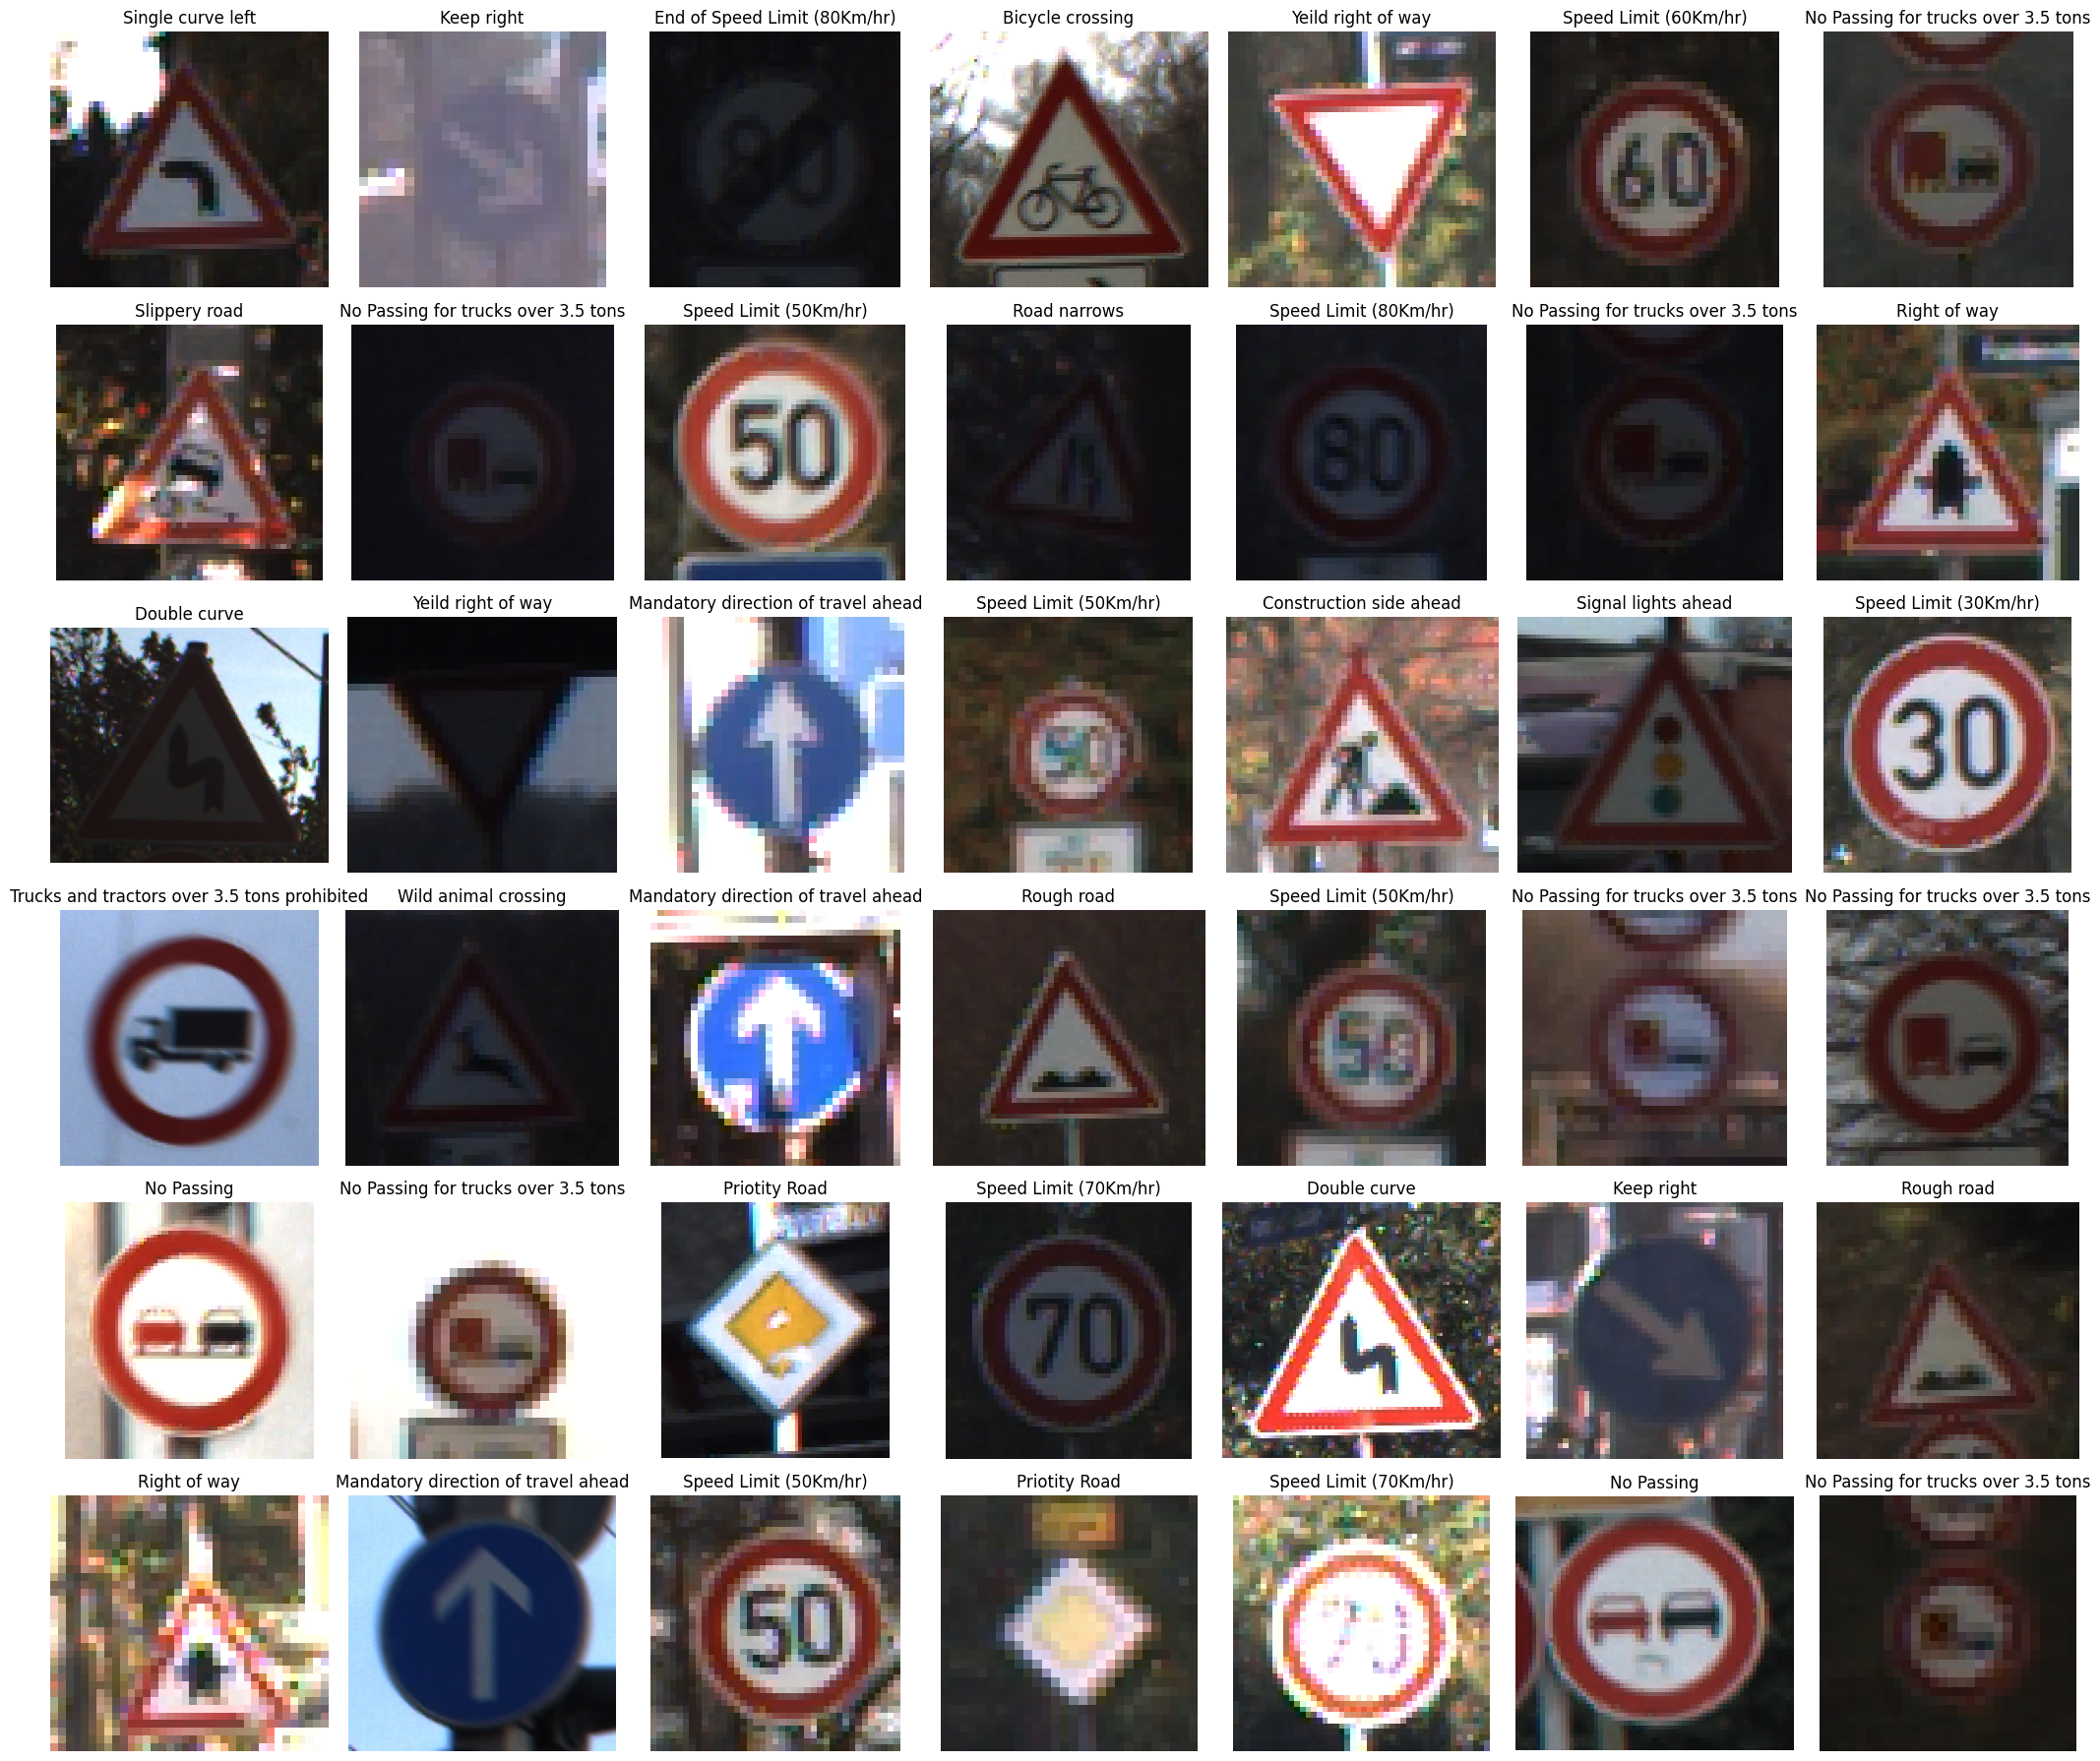

In [23]:
print_sample_images(6,7)

This random sample grid provides a quick overview of the diversity of our data. Immediately, we see that the images vary widely in quality; some signs appear well-lit and clear whilst others are blurred, heavily pixelated, or partially obstructed. This variation is important, as it reflects real-world conditions and highlights the level of robustness the model will need to handle.

We extend this further into generating images per class.

In [24]:
def random_sample_images_per_class():
    for c in sorted(train_df['ClassId'].unique()):
        folder = os.path.join(train_img_path, str(c))
        filenames = os.listdir(folder)
        
        sample_files = random.sample(filenames, min(5, len(filenames)))
        
        # Plot images
        plt.figure(figsize=(15, 3))
        class_name = class_names.get(c, f"Class {c}")
        plt.suptitle(f"{class_name} (Class {c})", fontsize=16)
        
        for i, f in enumerate(sample_files):
            img_path = os.path.join(folder, f)
            img = Image.open(img_path)
            
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.axis("off")
        
        plt.show()

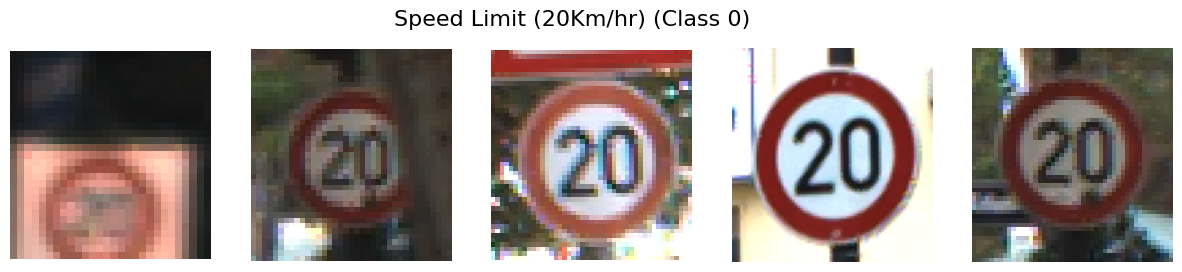

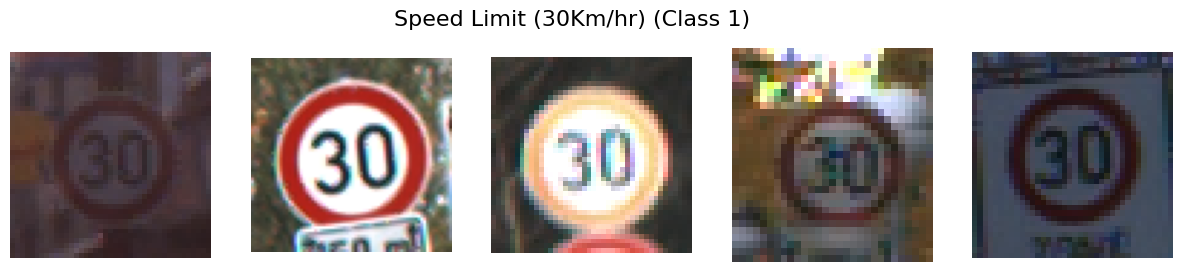

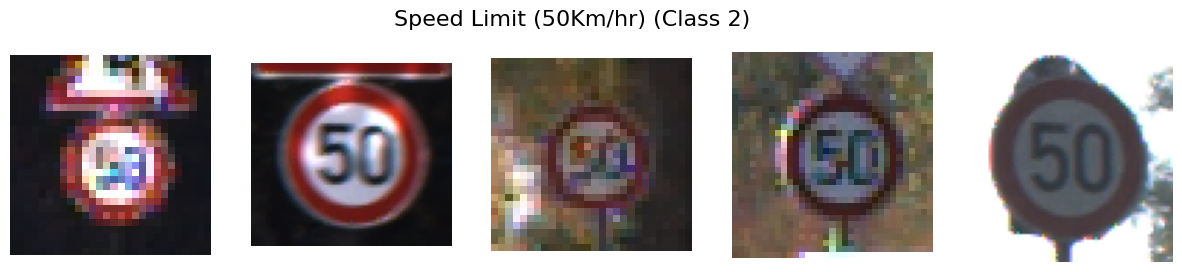

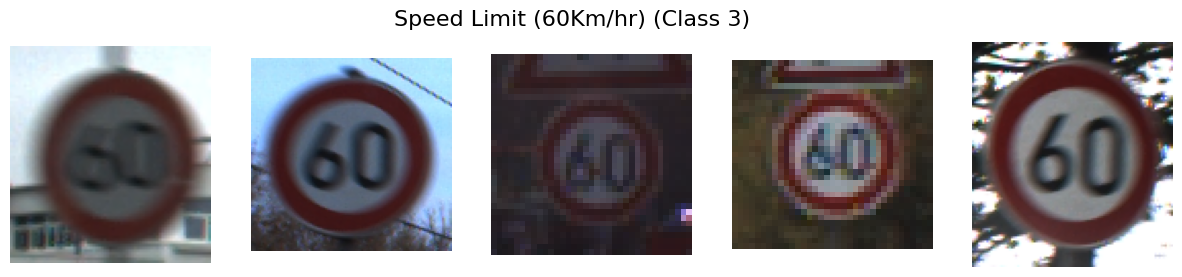

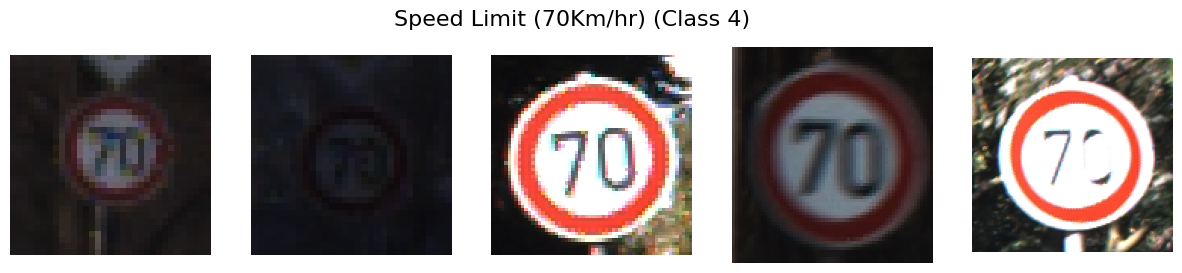

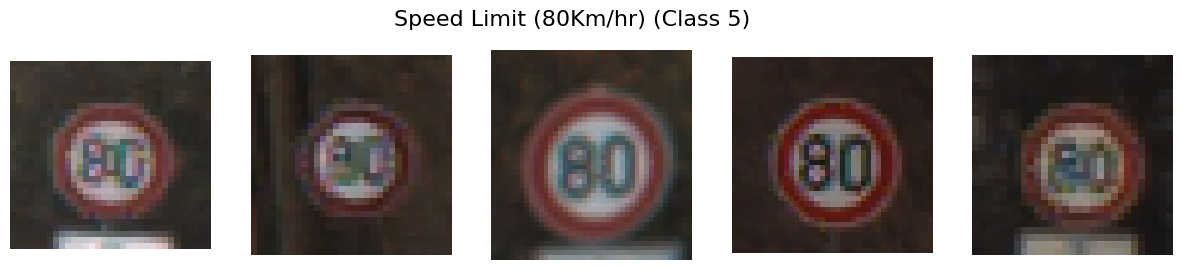

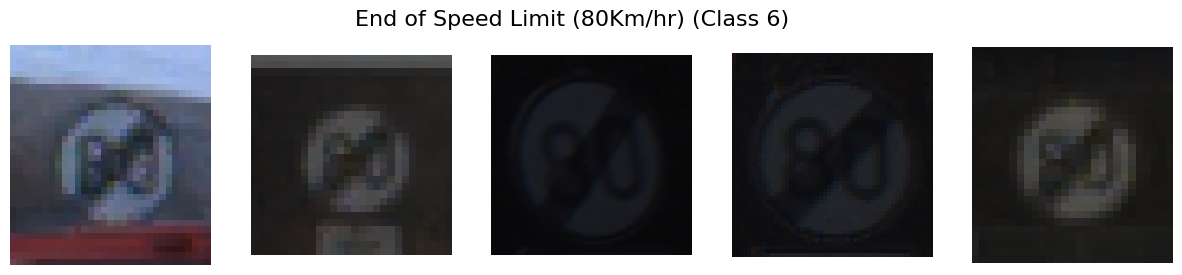

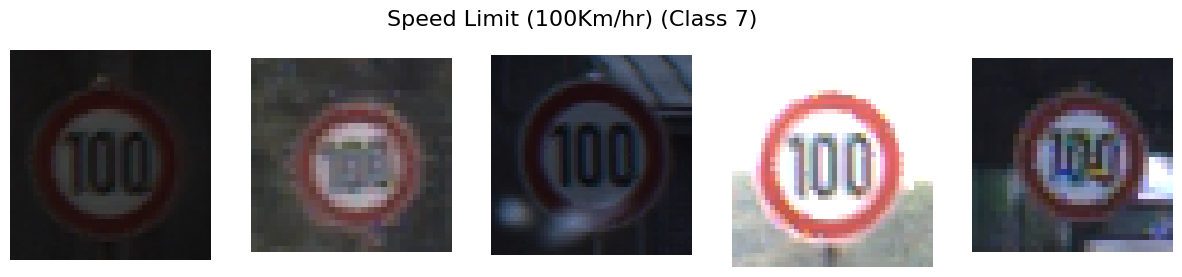

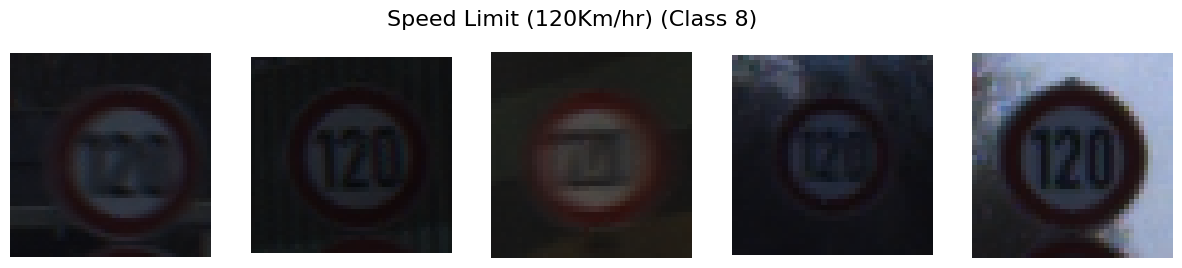

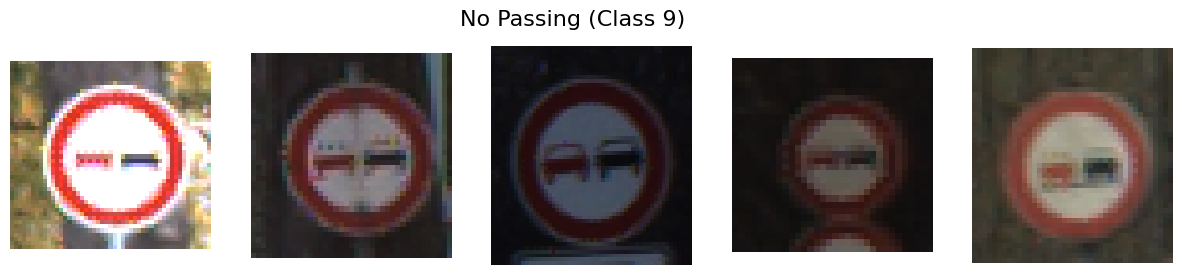

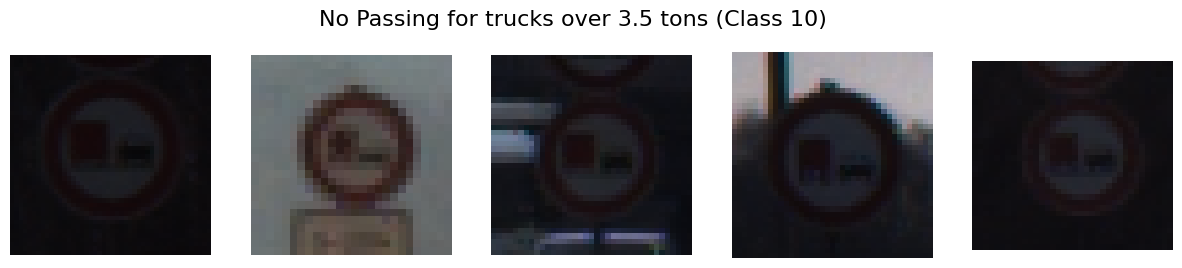

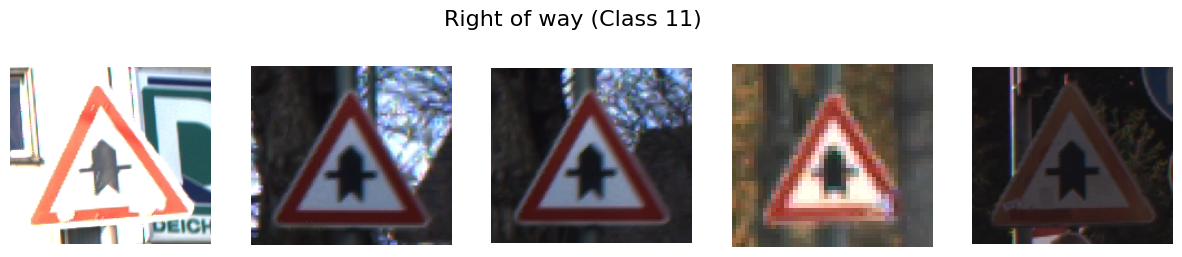

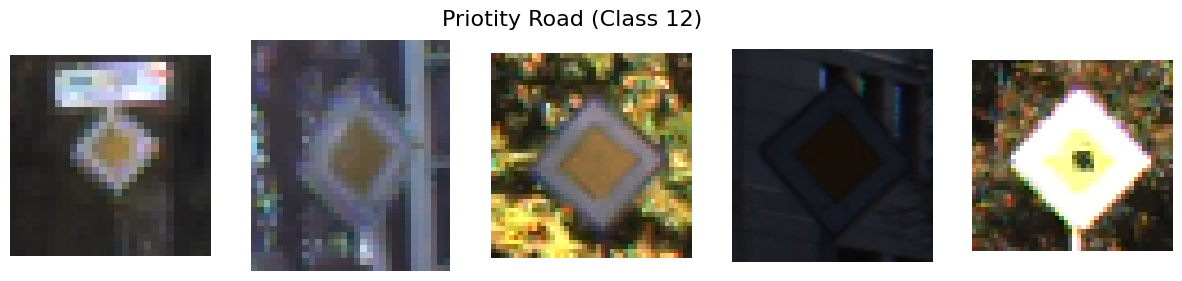

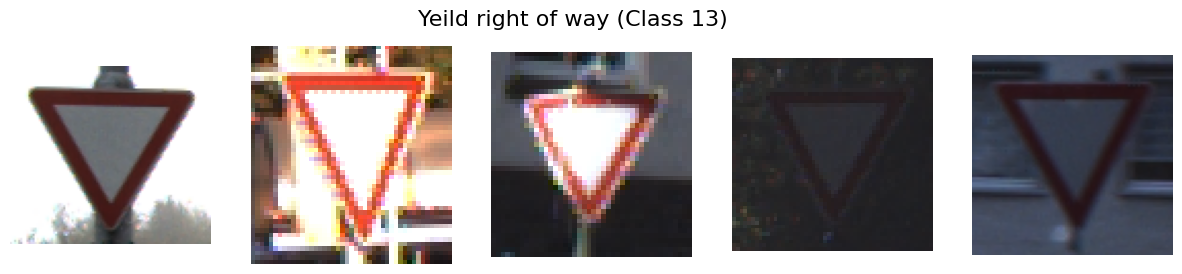

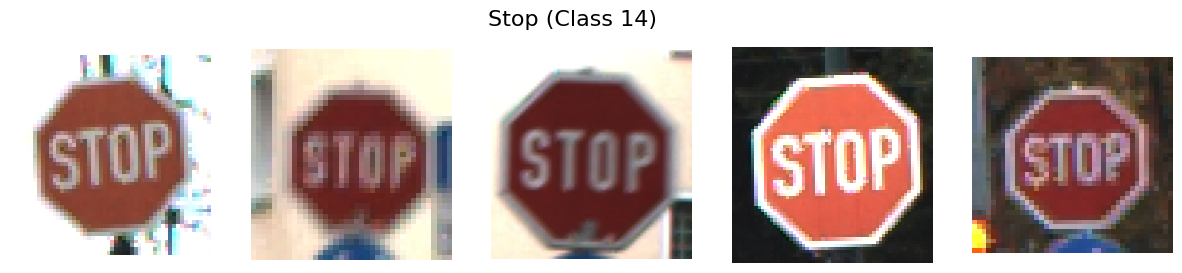

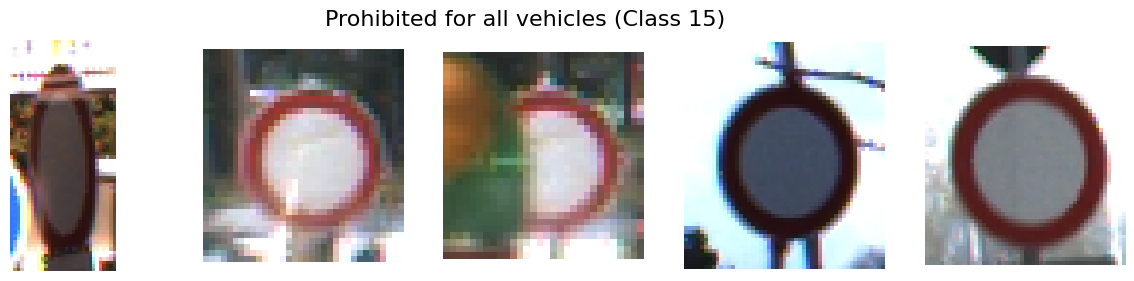

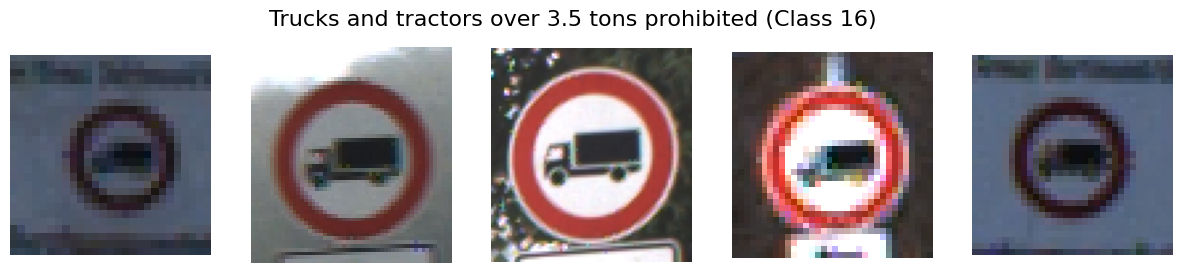

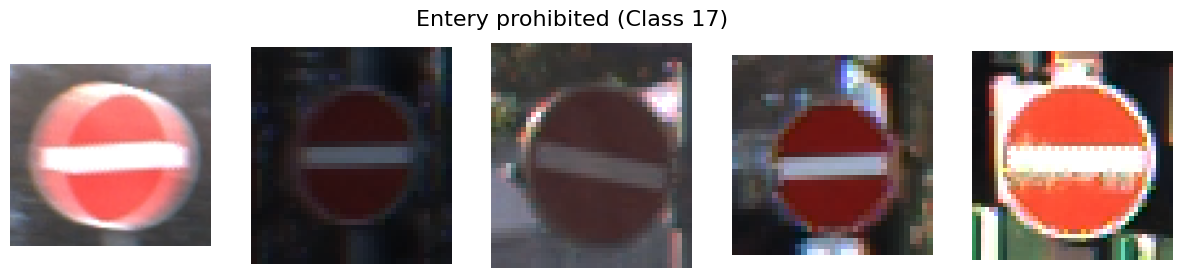

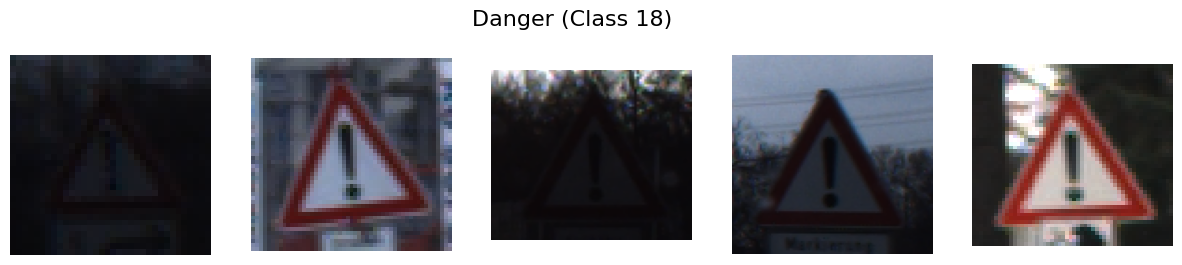

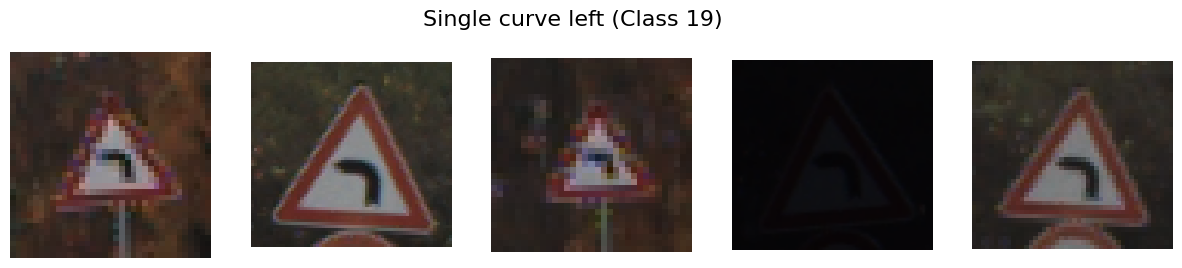

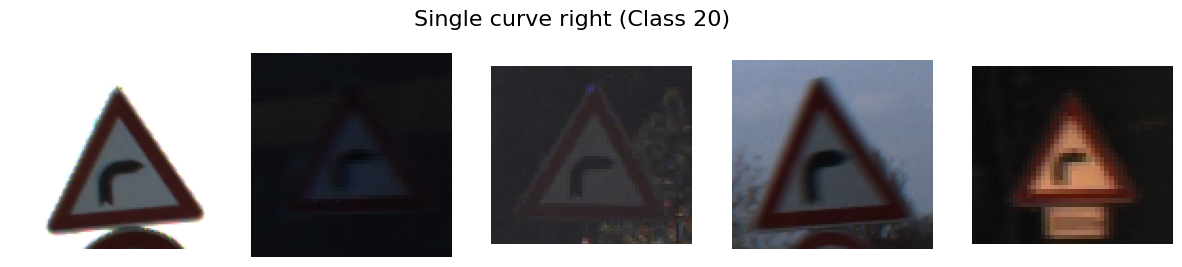

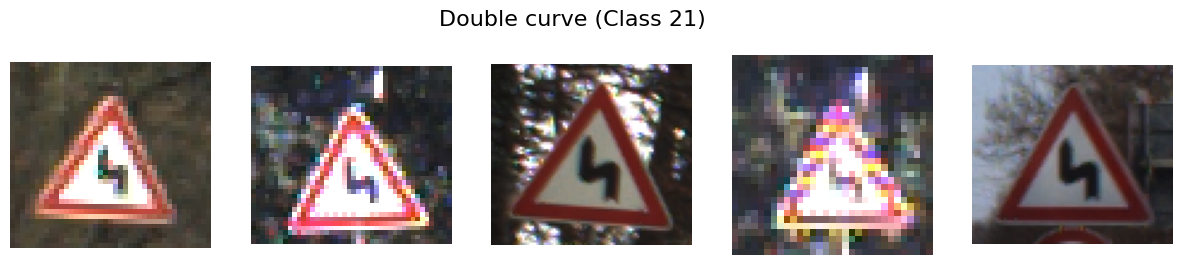

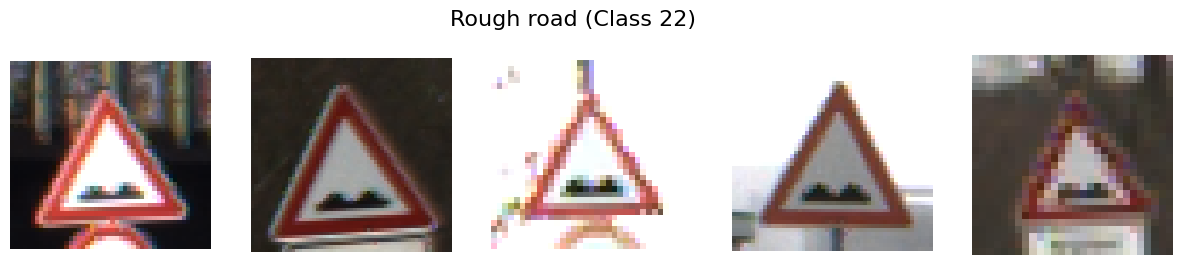

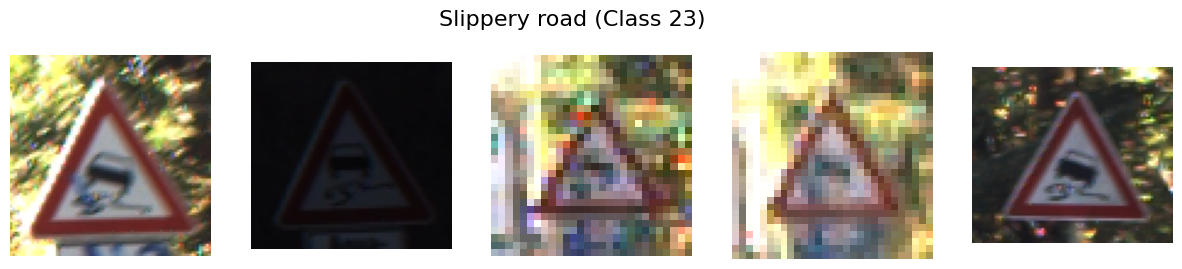

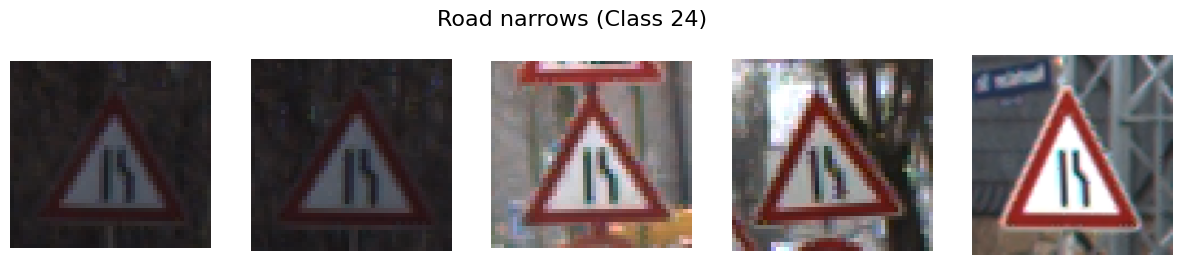

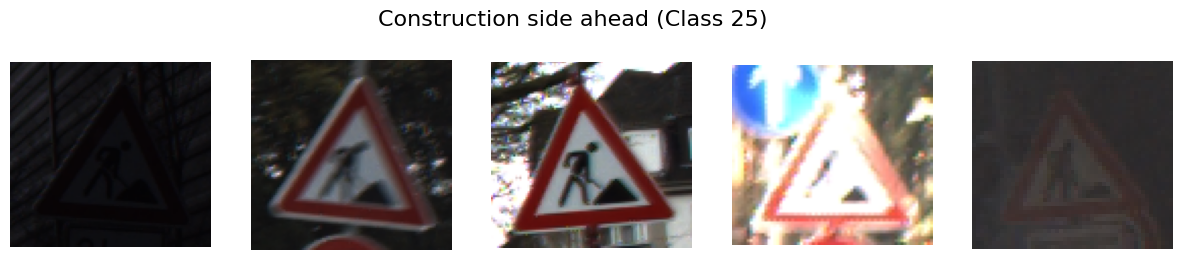

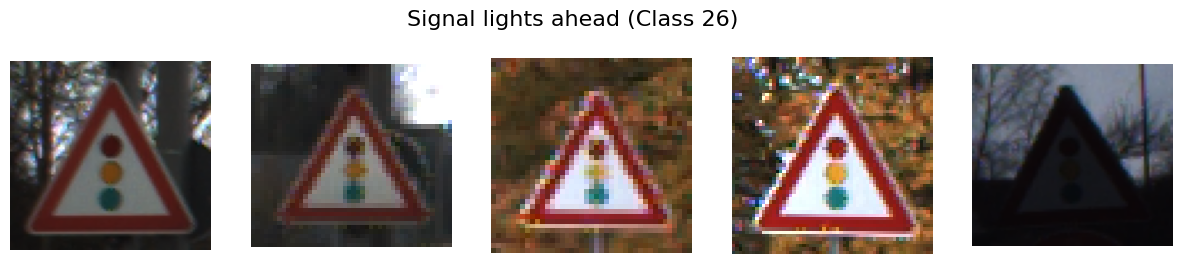

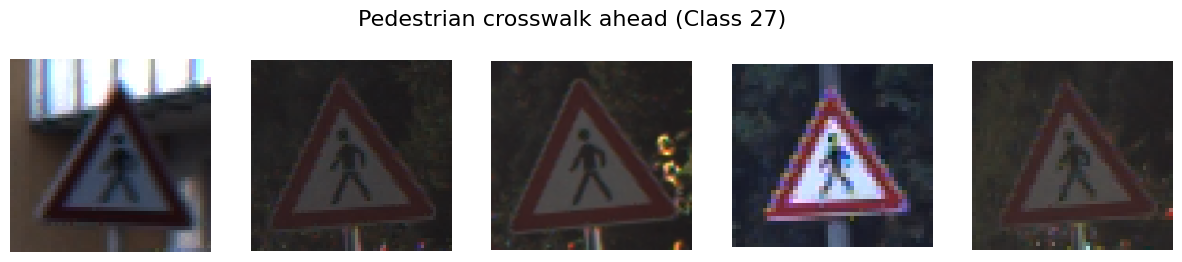

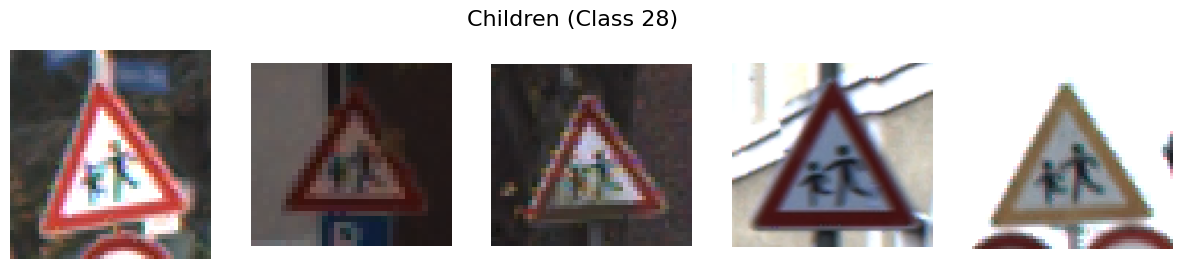

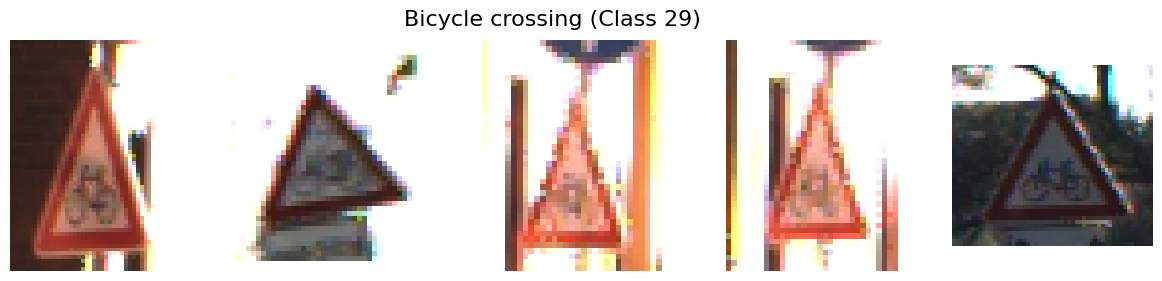

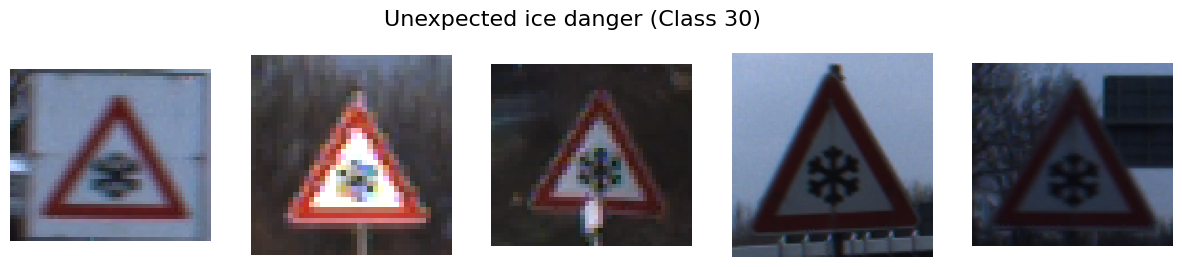

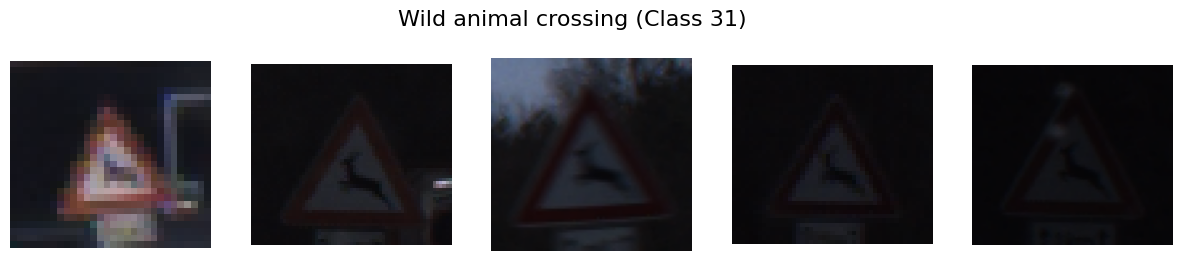

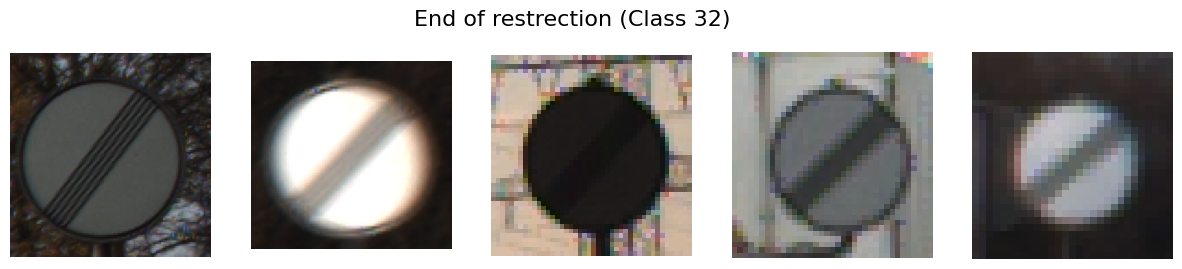

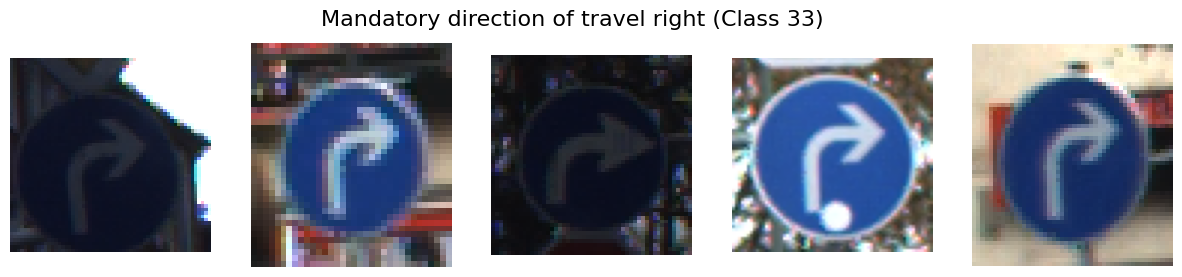

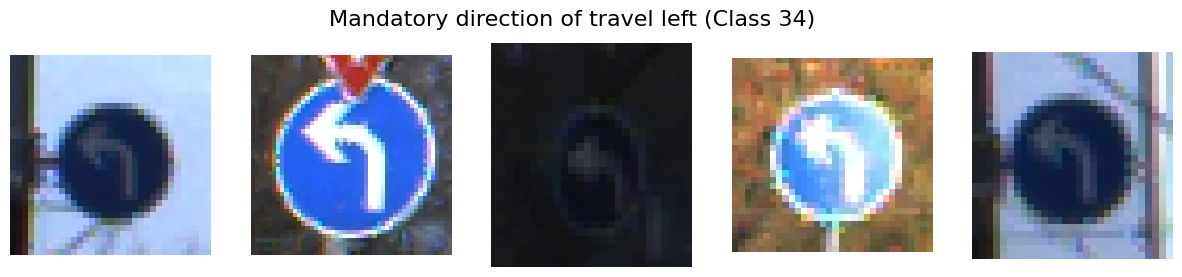

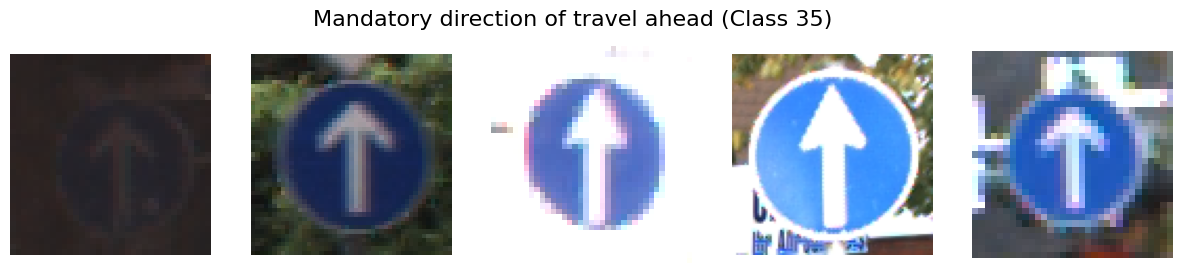

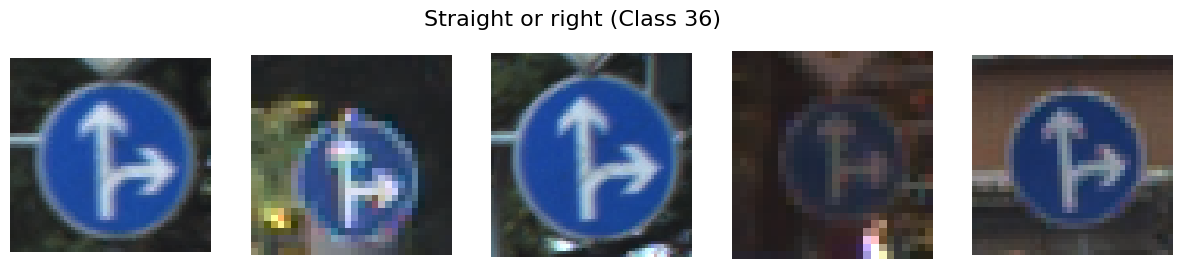

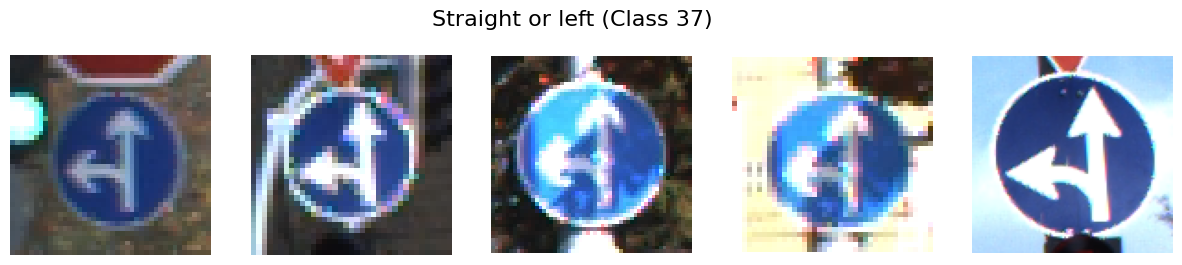

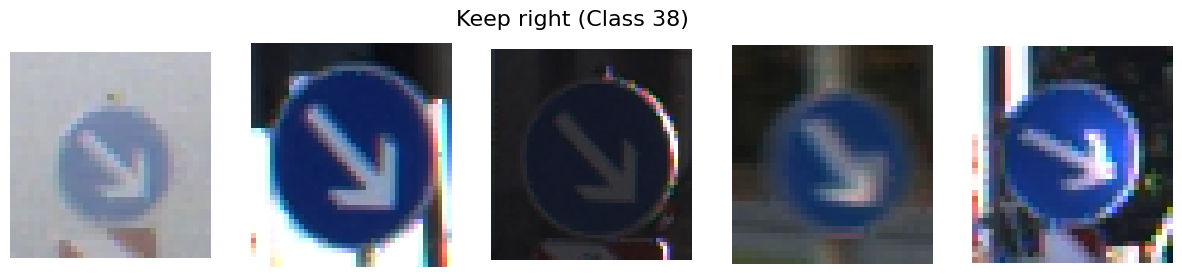

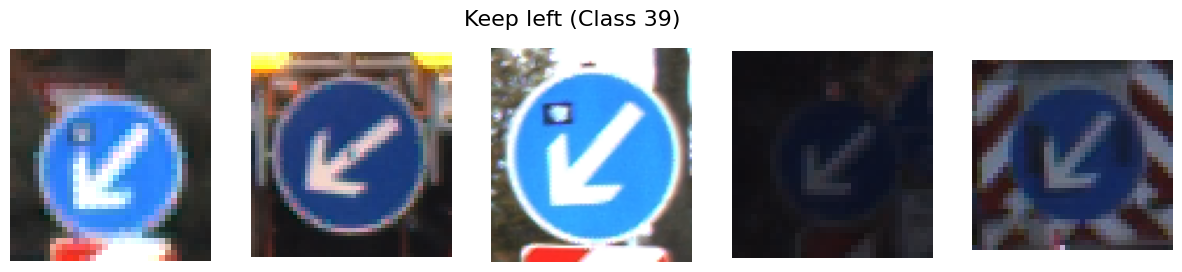

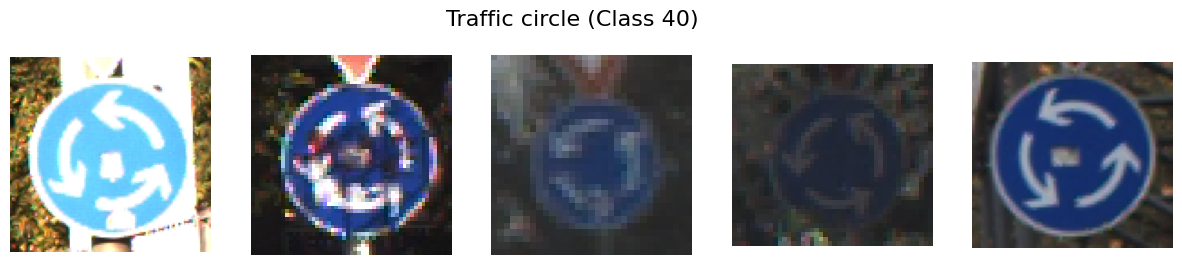

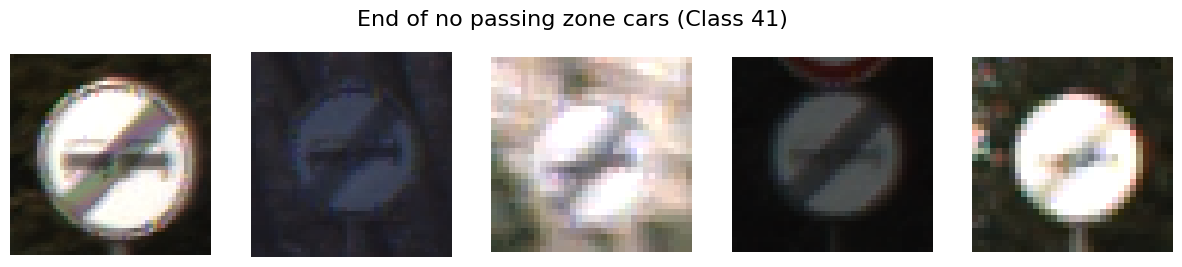

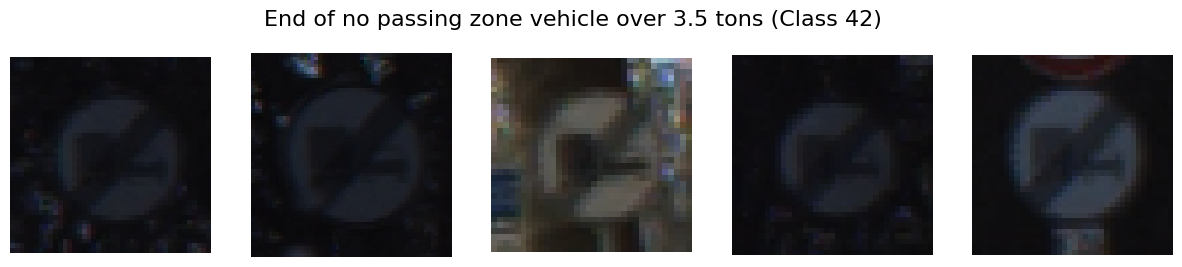

In [25]:
random_sample_images_per_class()

From inspecting the images above, we clearly see that there is a large variation in angle, quality, brightness and so on. This variation in image types will make it difficult for our models to consistently classify the correct traffic sign. Therefore we will conduct some meaningful preprocessing to try and minimise these issues. 

The resolution of images are very important to the preprocessing of data. We take a look at the most common types of resolution that the dataset contains and how this impacts our models.

In [26]:
# return list of (width, height) tuples
def resolutions(image_paths, max_images=None):
    resolutions = []
    for path in image_paths[:max_images]:
        with Image.open(path) as img:
            resolutions.append(img.size)
    return resolutions

resolutions(train_image_paths, max_images=15) # first 15 images

[(29, 30),
 (30, 30),
 (30, 30),
 (31, 31),
 (30, 32),
 (31, 31),
 (33, 34),
 (34, 35),
 (33, 34),
 (36, 36),
 (35, 36),
 (37, 38),
 (37, 38),
 (40, 39),
 (41, 42)]

Next we take a look at the most common types of resolutions, alongside minimum and maximum sizes, to identify any trends. For computational efficiency, we decide to only look at 5000 random images.

In [27]:
def reso_counter(image_paths, max_images=None):
    if max_images is None:
        max_images = 5000 # default to 5000 images
    
    # Randomly pick max_images from image_paths
    if max_images is not None:
        image_paths = random.sample(image_paths, max_images)

    res_list = resolutions(image_paths)  # now using random images
    res_counter = Counter(res_list)
    print("10 most common resolutions (Width x Height : Count):")
    for (w, h), count in res_counter.most_common(10): # only print the 10 most common results
        print(f"{w} x {h} : {count}")

    min_res = min(res_list, key=lambda x: x[0] * x[1])
    max_res = max(res_list, key=lambda x: x[0] * x[1])

    print("\nMinimum resolution:", f"{min_res[0]} x {min_res[1]}")
    print("Maximum resolution:", f"{max_res[0]} x {max_res[1]}")

reso_counter(train_image_paths, max_images=5000)

10 most common resolutions (Width x Height : Count):
30 x 30 : 55
36 x 36 : 51
33 x 34 : 50
31 x 32 : 49
35 x 35 : 48
29 x 29 : 48
31 x 31 : 47
32 x 32 : 47
38 x 38 : 46
32 x 33 : 45

Minimum resolution: 25 x 25
Maximum resolution: 197 x 179


Let us visualise these results to see the distribution of resolutions. Due to the large sample size of images, histograms should be a suitable tool for said visualisation [3].

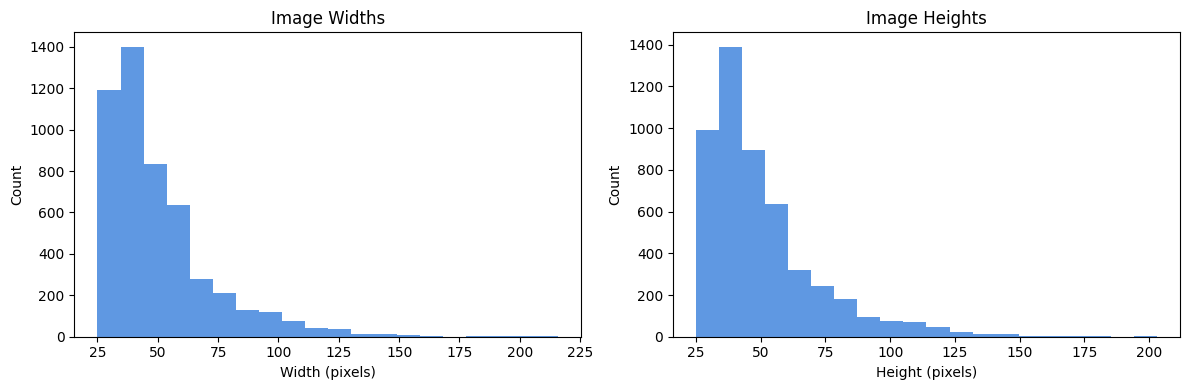

In [28]:
def reso_histogram(image_paths, max_images=None):
    widths, heights = zip(*resolutions(image_paths, max_images))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.hist(widths, bins=20, color="#5F98E2")
    ax1.set(xlabel="Width (pixels)", ylabel="Count", title="Image Widths")
    ax2.hist(heights, bins=20, color="#5F98E2")
    ax2.set(xlabel="Height (pixels)", ylabel="Count", title="Image Heights")
    plt.tight_layout()
    plt.show()

    return widths, heights

# only first 5000 images in dataset, can cross reference with above code to see common resolutions
widths, heights = reso_histogram(train_image_paths, max_images=5000) 

See that distributions for width and height are very similar. From before, we know most of the images have resolutions in the ~30 pixel range (for both width and height) but some images can go as low as 25 pixels to over 200 pixels, evidenced clearly from from the above histograms (note that this is only a sample of the first 5000 images mainly due to computational expense). This may cause issues for our models (class imbalance for example) and so preprocessing the data, such as resizing and normalisation, will be vital to ensure the models perform better. Thus, it is important we include certain architecture that can rectify these issues [3].

To get a sense of how bright or dark the dataset is overall, we can look at the distribution of pixel intensities in the images. Pixel values run from 0 to 255, with low values meaning darker areas and high values meaning brighter areas. Understanding this distribution helps us decide whether we need augmentation such as brightness shifts to make the model more robust. Plotting a histogram of pixel intensities for a sample of images gives a quick snapshot of how varied the lighting conditions are across the dataset.

In [29]:
def random_pixel_values():
    random.seed(1)
    pixel_values = []

    # take up to 10 random images from each class
    for c in sorted(train_df['ClassId'].unique()):
        folder = os.path.join(train_img_path, str(c))
        filenames = os.listdir(folder)
        sample_files = random.sample(filenames, min(10, len(filenames)))
        
        for f in sample_files:
            img = Image.open(os.path.join(folder, f)).convert('RGB')
            img_array = np.array(img)
            pixel_values.extend(img_array.flatten())

    return pixel_values

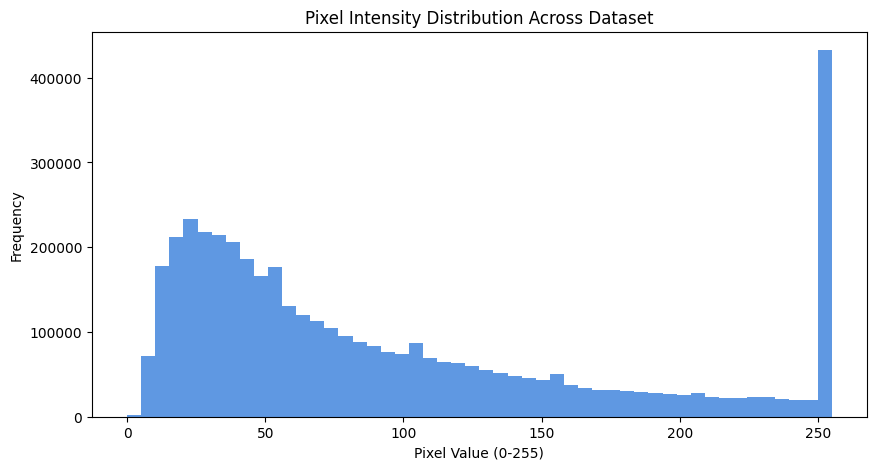

In [30]:
plt.figure(figsize=(10,5))
plt.hist(random_pixel_values(), bins=50, color='#5F98E2')
plt.title("Pixel Intensity Distribution Across Dataset")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()

In [31]:
pixels = np.array(random_pixel_values())

# Compute more statistics
print("Min pixel value:", np.min(pixels))
print("25th percentile:", np.percentile(pixels, 25))
print("Median (50th percentile):", np.median(pixels))
print("75th percentile:", np.percentile(pixels, 75))
print("Max pixel value:", np.max(pixels))
print("Mean pixel value:", np.mean(pixels))
print("Standard deviation:", np.std(pixels))

Min pixel value: 0
25th percentile: 34.0
Median (50th percentile): 68.0
75th percentile: 140.0
Max pixel value: 255
Mean pixel value: 95.94520895281562
Standard deviation: 77.30395544931827


The histogram and statistics shown above demonstrates that the dataset has a lot of dark pixels, some mid-brightness pixels, and a huge number of very bright pixels (which could be derived from the fact that white is a common colour on many traffic signs). It highlights the variation of lighting in the images and suggests that some form of brightness adjustment could be useful during training.

Now that we have collected information about pixel distributions, we can perform image augmentation. This means we will introduce some form of variability on the image to better capture the essence of randomness that will be present in real world instances.

In [32]:
random.seed(1)

def augment_image(img):
    # Rotation ±10°
    angle = random.uniform(-10, 10)
    img = img.rotate(angle)

    # Random horizontal and vertical shift (10% max)
    max_shift_x = int(0.1 * img.width)
    max_shift_y = int(0.1 * img.height)
    shift_x = random.randint(-max_shift_x, max_shift_x)
    shift_y = random.randint(-max_shift_y, max_shift_y)
    img = img.transform(img.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))

    # Random zoom/crop ±10%
    zoom_factor = random.uniform(0.9, 1.1)
    w, h = img.size
    new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
    img = img.resize((new_w, new_h), Image.BILINEAR)
    img = img.crop((0, 0, w, h))  # crop or pad back to original size

    # Brightness adjustment ±20%
    enhancer = ImageEnhance.Brightness(img)
    factor = random.uniform(0.8, 1.2)
    img = enhancer.enhance(factor)

    return img

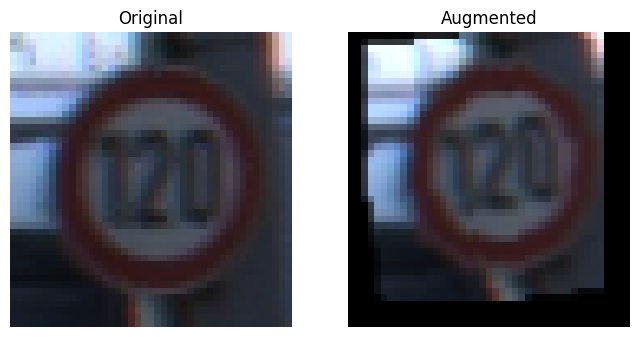

In [33]:
image_number = random.randint(0, 42)

img1 = random_image_generator(image_number)

aug_img1 = augment_image(img1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(aug_img1)
plt.title("Augmented")
plt.axis("off")
plt.show()

Finally, before we proceed onto the training of our models, we carefully reduce the size of our dataset by 50%. This is due to the heavy computational cost required to train such a model, as we do not have access to high grade equipment required to train on the full dataset. The code below carefully reduces the amount of images in each class by half, meaning the proportions of images per class is maintained.

In [34]:
classes = sorted(os.listdir(train_img_path))
print("Number of classes:", len(classes))

image_count = {}
half_dataset = []  # final list of selected images

for c in classes:
    folder = os.path.join(train_img_path, c)
    files = os.listdir(folder)

    # count images like your EDA
    image_count[c] = len(files)

    # take 50% of the images in this class
    half = len(files) // 2
    selected = np.random.choice(files, half, replace=False)

    # store full paths
    for f in selected:
        half_dataset.append(os.path.join(folder, f))

print("Original total images:", sum(image_count.values()))
print("Reduced total images:", len(half_dataset))

Number of classes: 43
Original total images: 39209
Reduced total images: 19604


This conducts our EDA and preprocessing part of the report. The aforementioned kaggle notebooks were used as the main source of information, followed by [4]. We now move onto the specific models used for classification.

References: 
<br>
[1] https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data
<br>
[2] https://www.kaggle.com/code/reemmuharram/traffic-sign-recognition-cnn-98
<br>
[3] https://www.kaggle.com/code/faldoae/exploratory-data-analysis-eda-for-image-datasets
<br>
[4] https://www.jaai.net/vol3/JAAI-V3N1-34.pdf
